In [354]:
import pandas as pd
import zipfile
import geopandas as  gpd
import numpy as np
from sklearn.cluster import KMeans, DBSCAN
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
import seaborn
import pylab as pl
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [311]:
#np.set_printoptions(precision=5, suppress=True)  # suppress scientific float notation

<br/>

## 1. Load NYC Zipcode Zone

In [96]:
zipNYC = gpd.read_file("nyc-zip-code-tabulation-areas-polygons.geojson")
# Change ColNames 
zipNYC = zipNYC.rename(columns={'postalCode': "zipcode"})
zipNYC = zipNYC.loc[:, ['zipcode', 'geometry', 'borough', 'PO_NAME']]
zipNYC.zipcode = pd.to_numeric(zipNYC.zipcode)
zipNYC.head()

,zipcode,geometry,borough,PO_NAME
0,11372,POLYGON ((-73.86942457284175 40.74915687096787...,Queens,Jackson Heights
1,11004,POLYGON ((-73.71068374074007 40.75004039450917...,Queens,Glen Oaks
2,11040,POLYGON ((-73.70098278625547 40.73889569923034...,Queens,New Hyde Park
3,11426,POLYGON ((-73.72270447144122 40.75373371438336...,Queens,Bellerose
4,11365,POLYGON ((-73.81088634744755 40.72717187575918...,Queens,Fresh Meadows


In [97]:
#print zipNYC.shape
#print zipNYC.dropna().shape
#if zipNYC.shape == zipNYC.dropna().shape:
#    print "No Zipcode Zone Has Empty Info."

# Unique Zipcode in NYC
print "# of All Zipcode: ", zipNYC.zipcode.unique().shape[0]
print "# of Unique Zipcode: ", zipNYC.shape[0]

# (Numeric) NYC Zipcode LIST
zipNYCList = pd.to_numeric(zipNYC.zipcode).values

# (Numeric NYC Zipcode UNIQUE LIST
zipNYCList_Unique = np.unique(zipNYCList)

# of All Zipcode:  247
# of Unique Zipcode:  262


In [95]:
# Some Special Zipcode Zone
zipNYC[zipNYC.zipcode == '00083']

,zipcode,geometry,borough,PO_NAME
82,00083,POLYGON ((-73.94922045816276 40.79690988348276...,Manhattan,Central Park


<br/><br/>

## 2. Load and Merge Census Business Data

In [136]:
Year = [str(i) for i in range(94, 100, 1)] + \
        ['0' + str(i) for i in range(0, 10, 1)] + \
        [str(i) for i in range(10, 15, 1)]

In [159]:
# Create a copy of zipNYC
temp = zipNYC.copy()

# Merge(1994-2014)
for year in Year:
    # Name
    fname = str('zbp' + year + 'totals.zip')
    colname_EST = str('EST' + year)  # colname of new adding column
    # Load
    zf = zipfile.ZipFile(fname)
    df = pd.read_csv(zf.open(fname.replace('.zip','.txt')))
    df.columns = map(str.upper, df.columns) # since there are cases 'ZIP' and 'EST' are lowercases.
    # Filter
    CB_NYC = df[np.in1d(df.ZIP, zipNYCList)].loc[:,['ZIP','EST']]
    # Merge
    CB_NYC = CB_NYC.rename(columns={'ZIP': 'zipcode'})
    temp = pd.merge(temp, CB_NYC, on='zipcode')
    # Colname
    temp = temp.rename(columns={"EST": colname_EST})

# create CB to store merged data
CB = temp

<br/><br/>

## 3. Standardlized CB

In [187]:
CB_mean = CB.iloc[:,range(4,25)].mean(axis=1)
CB_std = CB.iloc[:,range(4,25)].std(axis=1)
CB.iloc[:,range(4,25)] = CB.iloc[:,range(4,25)].apply(lambda x: (x- CB_mean) / CB_std)

In [200]:
CB.head(2)

,zipcode,geometry,borough,PO_NAME,EST94,EST95,EST96,EST97,EST98,EST99,...,EST05,EST06,EST07,EST08,EST09,EST10,EST11,EST12,EST13,EST14
0,11372,POLYGON ((-73.86942457284175 40.74915687096787...,Queens,Jackson Heights,-1.650515,-1.607088,-1.259673,-1.154208,-0.893647,-0.738551,...,0.272673,0.198227,0.309896,0.266469,0.477400,0.831018,0.942687,1.420382,1.637516,1.693350
1,11004,POLYGON ((-73.71068374074007 40.75004039450917...,Queens,Glen Oaks,-0.974535,-1.248013,-1.794968,-1.065695,-0.974535,-1.339172,...,0.438432,0.484012,1.030967,0.529592,0.803069,0.620751,0.301694,1.167706,1.167706,1.577923


<br/><br/>

## 4. KMeans

In [312]:
mod_km = KMeans(n_clusters=4, init='k-means++', n_init=10, max_iter=300, tol=0.0001, 
                verbose=0, random_state=None, algorithm='auto').fit(CB.iloc[:,range(4,25)])

In [313]:
centers = mod_km.cluster_centers_

### For Example, set EST94 and EST14 as x/y axis and plot cluster centers 

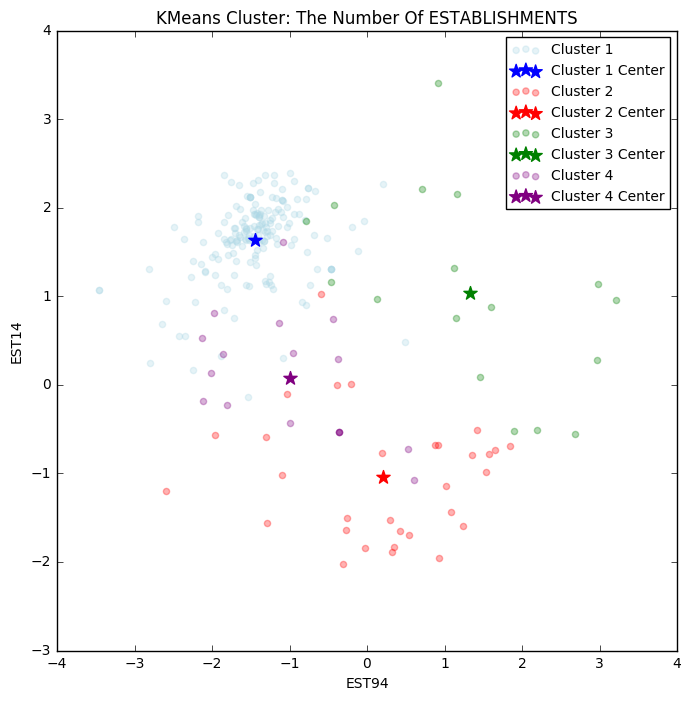

In [315]:
pl.figure(figsize=(8,8))
pl.scatter(CB[mod_km.labels_ == 0].iloc[:,4], CB[mod_km.labels_ == 0].iloc[:,24], \
           color='lightblue', alpha=0.3, label="Cluster 1")
pl.scatter(centers[0][0], centers[0][-1], marker='*', s=100, color='blue', label="Cluster 1 Center")

pl.scatter(CB[mod_km.labels_ == 1].iloc[:,4], CB[mod_km.labels_ == 1].iloc[:,24], \
           color='red', alpha=0.3, label="Cluster 2")
pl.scatter(centers[1][0], centers[1][-1], marker='*', s=100, color='red', label="Cluster 2 Center")

pl.scatter(CB[mod_km.labels_ == 2].iloc[:,4], CB[mod_km.labels_ == 2].iloc[:,24], \
           color='green', alpha=0.3, label="Cluster 3")
pl.scatter(centers[2][0], centers[2][-1], marker='*', s=100, color='green', label="Cluster 3 Center")

pl.scatter(CB[mod_km.labels_ == 3].iloc[:,4], CB[mod_km.labels_ == 3].iloc[:,24], \
           color='purple', alpha=0.3, label="Cluster 4")
pl.scatter(centers[3][0], centers[3][-1], marker='*', s=100, color='purple', label="Cluster 4 Center")

# pl.scatter(CB[mod_km.labels_ == 4].iloc[:,4], CB[mod_km.labels_ == 4].iloc[:,24], \
#            color='orange', alpha=0.3, label="Cluster 5")
# pl.scatter(centers[4][0], centers[4][-1], marker='*', s=100, color='orange', label="Cluster 5 Center")

pl.xlabel("EST94")
pl.ylabel("EST14")
pl.title("KMeans Cluster: The Number Of ESTABLISHMENTS")
pl.legend(fontsize=10, loc='best')

#### Plot above shows the result of KMeans Cluster for EST94~EST14. Here it shows Two dimension EST94 and EST14. And it is obvious that data points from different clusters gather aroud their own cluster centers.  

<br/><br/>

## 5. DBSCAN

In [323]:
mod_DBSCAN = DBSCAN(min_samples=4).fit(CB.iloc[:,range(4,25)])

In [324]:
unique(mod_DBSCAN.labels_)

array([-1,  0,  1,  2,  3])

### DBSCAN: 5 Clusters In Total

<br/><br/> 
## 6. Hierarchical Clustering

In [328]:
Z = linkage(CB.iloc[:,range(4,25)], 'ward')

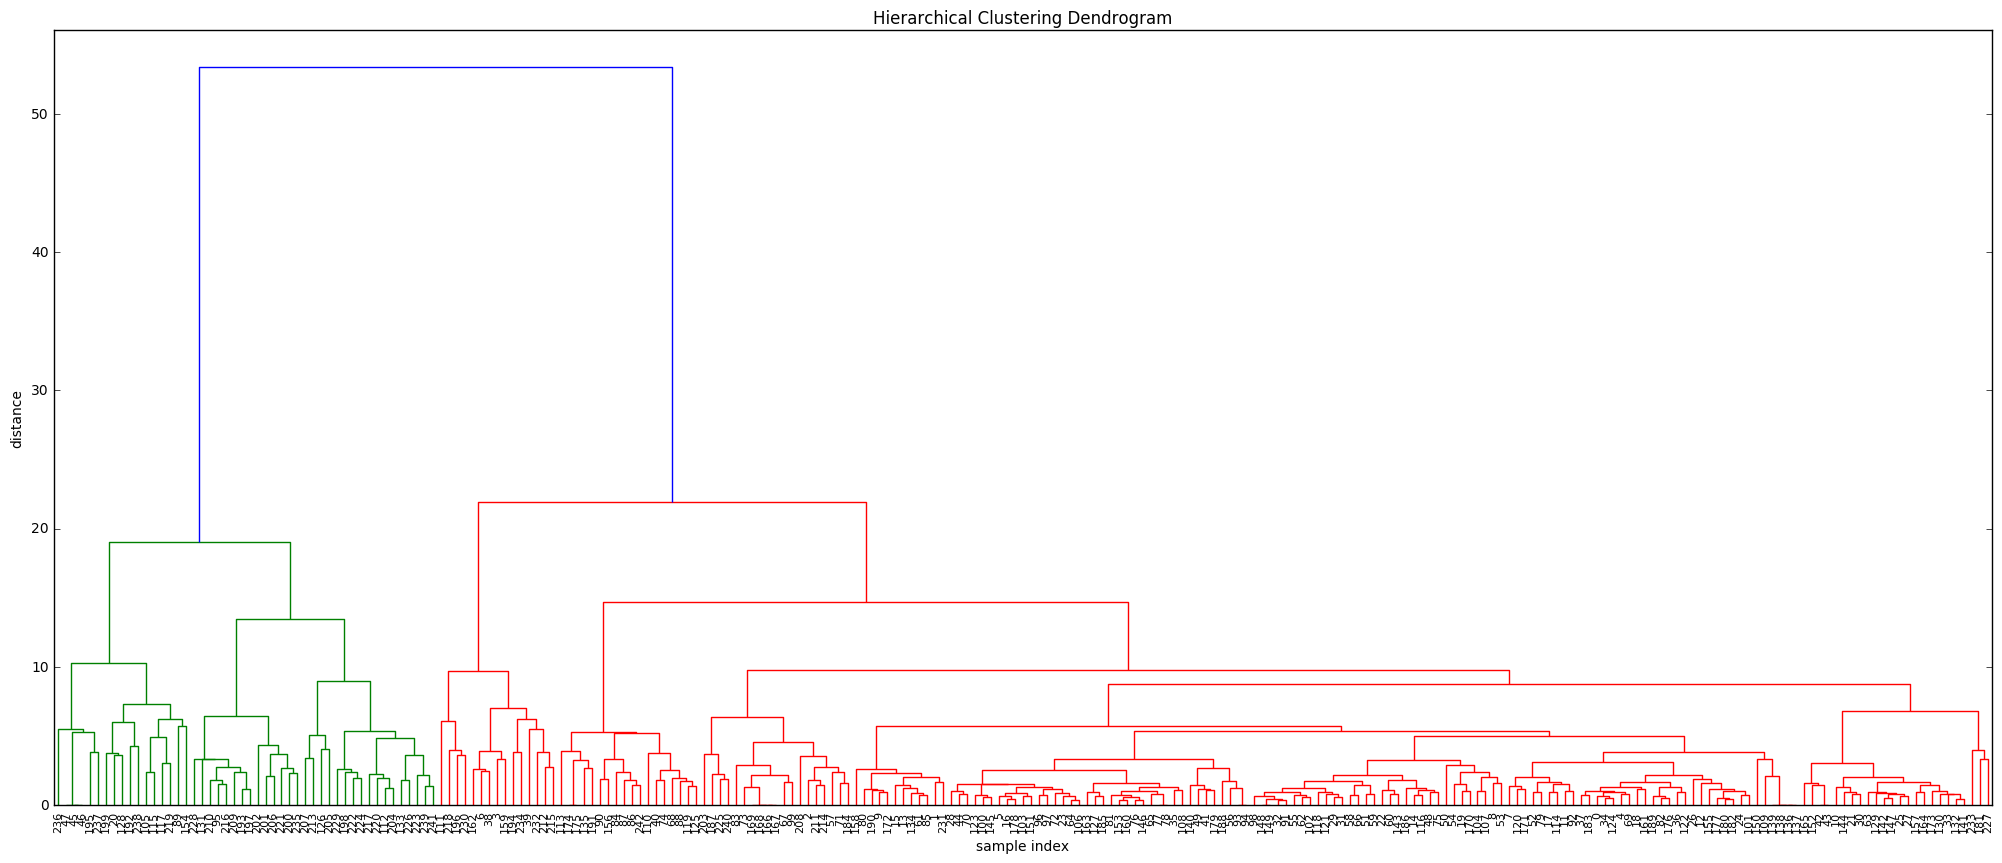

In [335]:
plt.figure(figsize=(25, 10))
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('sample index')
plt.ylabel('distance')
dendrogram(
    Z,
    leaf_rotation=90.,  # rotates the x axis labels
    leaf_font_size=8.,  # font size for the x axis labels
)
pl.show()

### Plot above shows the result of hierarchical clustering.

In [359]:
HC_label = fcluster(Z, 4, criterion='maxclust')

<br/><br/>
## 7. Plot

In [376]:
CB2 = CB.copy()
CB2['km'] = mod_km.labels_
CB2['DBSCAN'] = mod_DBSCAN.labels_
CB2['HC'] = HC_label
CB2['HC_'] = CB2.HC.replace([1,4],[4,1])

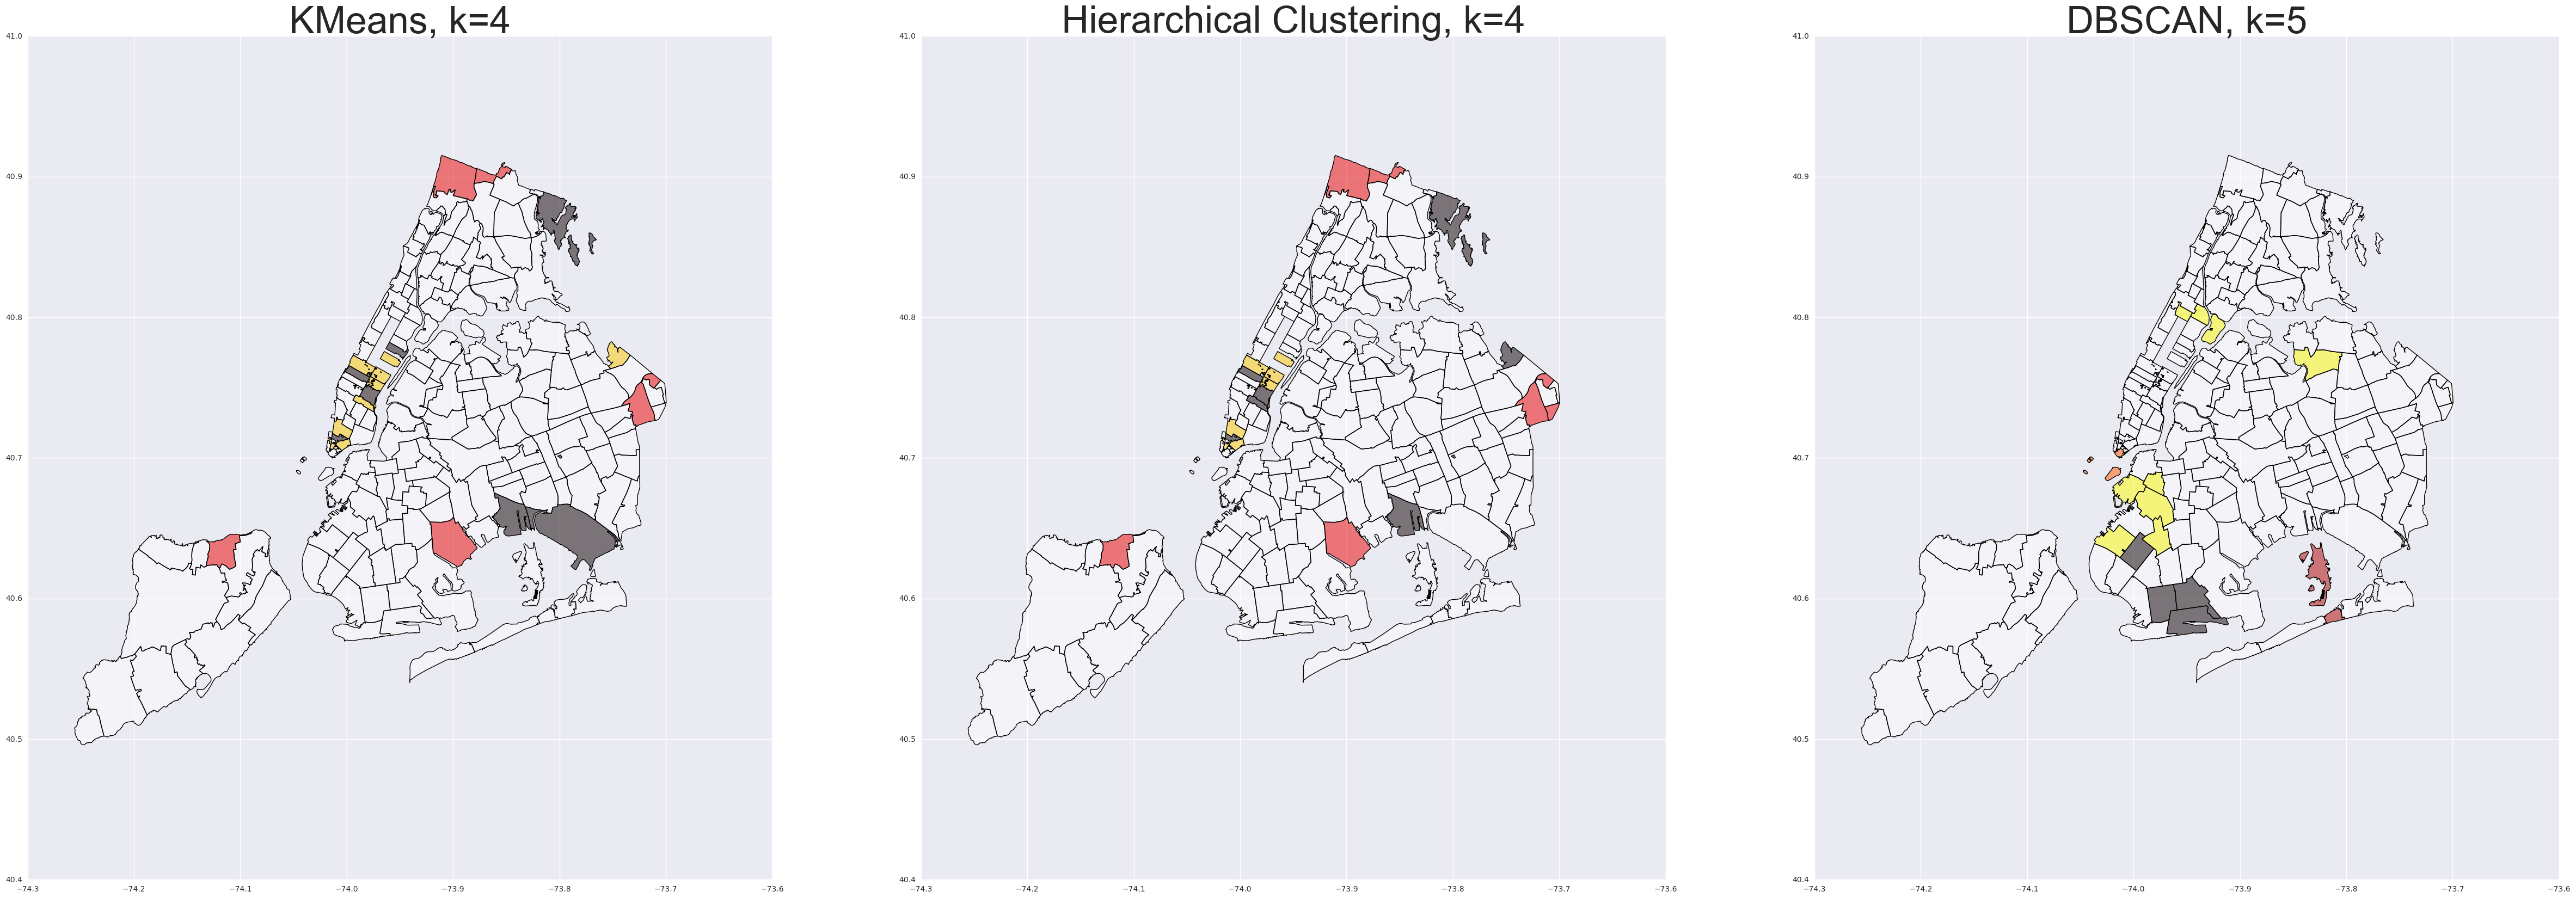

In [379]:
f, (ax1, ax2, ax3) = pl.subplots(1,3,figsize=(60,20))
CB2.plot(colormap='hot_r', column='km', ax=ax1, categorical=True, k=4)
ax1.set_title("KMeans, k=4", fontsize=50)
CB2.plot(colormap='hot_r', column='HC_', ax=ax2, categorical=True, k=4)
ax2.set_title("Hierarchical Clustering, k=4", fontsize=50)
CB2.plot(colormap='hot_r', column='DBSCAN', ax=ax3, categorical=True, k=5)
ax3.set_title("DBSCAN, k=5", fontsize=50)

### Plots above show the cluster result of each cluster methods, combining with zipcode map.
### Mainly focus on the first two maps (KMeans and Hierarchical Cluster). Both Cluster Methods show similar results. 

<br/><br/>
## 8. Interpretation and Exploration

##### To be honest, It's really hard to find out pattern of zipcode zone which are in the same clusters. 
##### While Most of area in NYC are in "White" clusters, Few with certain spatila patterns are in "red", "yellow" and "grey" clusters. 
##### One possible guess is that "yellow" zipcode areas are places always with large amount of constructions, like roads rebuilding, since those areas all around mid and lower Manhattan. And 'Red' and "grey" areas are more likely the deserted places in which few constructions happened or emerging areas that more and more projects take place. 